## Introduction
Fraud risk is everywhere, but for companies that advertise online, click fraud can happen at an overwhelming volume, resulting in misleading click data and wasted money. Ad channels can drive up costs by simply clicking on the ad at a large scale. With over 1 billion smart mobile devices in active use every month, China is the largest mobile market in the world and therefore suffers from huge volumes of fradulent traffic.

TalkingData, China’s largest independent big data service platform, covers over 70% of active mobile devices nationwide. They handle 3 billion clicks per day, of which 90% are potentially fraudulent. Their current approach to prevent click fraud for app developers is to measure the journey of a user’s click across their portfolio, and flag IP addresses who produce lots of clicks, but never end up installing apps. With this information, they've built an IP blacklist and device blacklist.

While successful, they want to always be one step ahead of fraudsters and have turned to the Kaggle community for help in further developing their solution. In their 2nd competition with Kaggle, you’re challenged to build an algorithm that predicts whether a user will download an app after clicking a mobile app ad. To support your modeling, they have provided a generous dataset covering approximately 200 million clicks over 4 days!

### Importing the data and python packages

In [1]:
import pandas as pd
import numpy as np
import sklearn
import gc

In [2]:
test_data = pd.read_csv('data/test.csv')
test_data.sample(5)

,click_id,ip,app,device,os,channel,click_time
15614736,15614737,2805,13,1,19,400,2017-11-10 14:01:23
390807,390807,73031,12,1,19,481,2017-11-10 04:06:58
17152112,17152112,114341,15,1,25,278,2017-11-10 14:29:00
7341052,7341052,24249,3,1,12,205,2017-11-10 09:22:40
10246533,10246533,31784,23,1,19,153,2017-11-10 10:20:35


In [3]:
train_data = pd.read_csv('data/train.csv', nrows=50000000)
train_data.sample(5)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
35902765,106929,12,1,13,259,2017-11-07 08:13:11,NaN,0
47451993,76917,1,1,19,150,2017-11-07 12:00:04,NaN,0
27739862,115661,12,1,13,259,2017-11-07 05:27:54,NaN,0
21282140,63790,15,1,10,3,2017-11-07 03:37:05,NaN,0
16100804,55725,12,1,17,265,2017-11-07 01:57:43,NaN,0


### Check for missing values

In [4]:
missing_values_count = train_data.isnull().sum()
missing_values_count

ip                        0
app                       0
device                    0
os                        0
channel                   0
click_time                0
attributed_time    49868767
is_attributed             0
dtype: int64

We only have missing values in the atttributed_time. You can choose to drop the columm or fill the missing the values. I will fill the missing data.

In [5]:
train_data = train_data.fillna(0)

In [6]:
# missing test_data
missing_values_count = test_data.isnull().sum()
missing_values_count

click_id      0
ip            0
app           0
device        0
os            0
channel       0
click_time    0
dtype: int64

### Change the datetime field

In [7]:
def change_date(df, time):
    r_time = pd.to_datetime(time)
    df['hour'] = pd.to_datetime(r_time).dt.hour.astype('uint8')
    df['day'] = pd.to_datetime(r_time).dt.day.astype('uint8')
    return df

In [8]:
# datetime on test.data
change_date(test_data, test_data.click_time)
test_data.sample(5)


,click_id,ip,app,device,os,channel,click_time,hour,day
11454137,11454137,40501,1,1,11,135,2017-11-10 10:43:22,10,10
8240340,8240340,114490,2,1,13,205,2017-11-10 09:41:12,9,10
4346472,4346472,28362,9,1,41,442,2017-11-10 05:20:10,5,10
5803819,5803819,100871,3,1,11,452,2017-11-10 05:50:53,5,10
7244724,7244723,65285,29,1,13,213,2017-11-10 09:20:42,9,10


In [9]:
# change on train data
change_date(train_data, train_data.click_time)
train_data.sample(5)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,hour,day
37808003,93054,28,1,14,135,2017-11-07 08:54:50,0,0,8,7
36567763,86154,15,1,6,245,2017-11-07 08:27:53,0,0,8,7
16610271,18274,12,1,13,178,2017-11-07 02:07:17,0,0,2,7
45730922,26929,24,1,70,178,2017-11-07 11:26:15,0,0,11,7
5178121,55212,2,1,47,122,2017-11-06 20:54:23,0,0,20,6


### Analyse the feature and group

In [10]:
def group(dataset, g, x):
    gp = dataset.groupby(by=g)[['channel']].count().reset_index().rename(index=str, columns={'channel': x})
    dataset = dataset.merge(gp, on=g, how='left')
    return dataset

In [11]:
# ip-click_time_combination
x = 'ip_tcount'
g = ['ip','day','hour']
test_data = group(test_data, g, x )
train_data = group(train_data, g, x)

In [12]:
# ip-app_os combination
x = 'ip_app_os_count'
g = ['ip','app','os']
test_data = group(test_data, g, x )
train_data = group(train_data, g, x)

In [13]:
# ip-device_os combination
x = 'ip_device_os_count'
g = ['ip','device','os']
test_data = group(test_data, g, x )
train_data = group(train_data, g, x)

In [14]:
# ip_app, device combination
x = 'ip_app_device_os_count'
g = ['ip', 'app', 'device', 'os']
test_data = group(test_data, g, x)
train_data = group(train_data, g, x)

In [15]:
#  splitting the data
from sklearn.cross_validation import train_test_split

feature_colums = ['app', 'device','os', 'channel', 'hour', 'day', 
              'ip_tcount', 'ip_app_os_count',
              'ip_device_os_count', 'ip_app_device_os_count']
label_colums = ['is_attributed']

# Create features and labels
X = train_data[feature_colums].values
y = train_data[label_colums].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train.shape

/Users/rose/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(35000000, 10)

In [16]:
# training the model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, log_loss


model = LogisticRegression(class_weight='balanced', C=1.e4 / X.shape[0])
print('fitting the model')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)

print('results')
print("accuracy ", accuracy_score(y_test, y_pred))
print(" log_loss " ,  log_loss(y_test, y_pred_proba))
print(" auc is %2.3f", auc(fpr, tpr))



fitting the model


/Users/rose/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


results
accuracy  0.7691313333333333
 log_loss  0.5580541635282775
 auc is %2.3f 0.8138418411787827


#### Plotting a ROC AUC curve


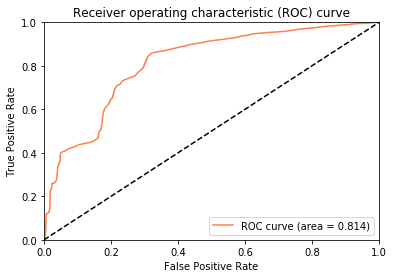

In [20]:
import matplotlib.pyplot as plt
plt.figure()
# plotting true positive rate vs false positive rate
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')

# get the x limits of both axes
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()


In [18]:
# testing the model
test_pred = pd.DataFrame()
test_pred['click_id'] = test_data['click_id'].astype('int')
test_pred.head()
final_test = test_data[feature_colums].values
predictions = model.predict_proba(final_test)[:, 1]
test_pred['is_attributed'] = predictions
test_pred.to_csv('submission_sk.csv', index=False)

In [19]:
test_pred.head(5)

,click_id,is_attributed
0,0,0.744709
1,1,0.426119
2,2,0.827700
3,3,0.785938
4,4,0.588855
